In [507]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re

To do list:

1. filter government response data to find when each measure was enacted for each country.
2. Get population and testing data for weights
3. calculate average rate of (daily?) growth rates (case data, test data, pop data)
4. TWO_WAY ANOVA where countries are FACTOR A, response type is FACTOR B and BEFORE AFTER are the N's.

Import the .csv file that contains information on government responses and action events.

In [508]:
response_df = pd.read_csv('./OxCGRT_Download_180420_014315_Full.csv')
response_df.tail()

,CountryName,CountryCode,Date,S1_School closing,S1_IsGeneral,S1_Notes,S2_Workplace closing,S2_IsGeneral,S2_Notes,S3_Cancel public events,...,S11_Notes,S12_Testing framework,S12_Notes,S13_Contact tracing,S13_Notes,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,Unnamed: 39
15981,Kosovo,RKS,20200413,2.0,1.0,"On 26 Mar 2020, the Government decided to exte...",2.0,0.0,Public Health Emergency declared on 15 March 2...,2.0,...,NaN,2.0,NaN,2.0,NaN,283.0,7.0,90.48,90.48,\t
15982,Kosovo,RKS,20200414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,387.0,8.0,NaN,90.48,\t
15983,Kosovo,RKS,20200415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,387.0,8.0,NaN,90.48,\t
15984,Kosovo,RKS,20200416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,449.0,11.0,NaN,90.48,\t
15985,Kosovo,RKS,20200417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,480.0,12.0,NaN,90.48,\t


Slice out all "notes" and targeted vs. general response columns. This currently goes beyond what I want to do. Also
merge day, month, year data into single date timestamp

In [509]:
response_df_edit = response_df.copy()
for x in response_df.columns:
    if (x.count('Notes')>0) | (x.count('IsGeneral')>0):
        response_df_edit.drop(columns=x, inplace=True)
        
response_df_edit.drop(columns='Unnamed: 39', inplace=True)
response_df_edit.loc[:, 'Date'] = pd.to_datetime(response_df_edit.Date, format='%Y%m%d', errors='coerce')

For WHATEVER reason, I cannot use idxmin or idxmax to get the correct date when the date is the index, but
if DATE is kept as a column I can use max or min. 

Two-way ANOVA: Factor A will be quarantine type? Factor B is Country? Only count countries where
quarantine has been active for 2 weeks consectutively. The trials will be the time series. (weighted by population, and number of tests).

Take a subset of data which has implemented all quarantine measures that will be tested. 
The quantifiable measure will be 


OK: averaging over the time series is dubious because of confounding factors. 

In [510]:
group_by_country = response_df_edit.groupby(by=['CountryName','Date']).sum()

In [511]:
group_by_country.columns = ['_'.join(y.split(' ')) for y in [x.split('_')[-1] for x in group_by_country.columns.tolist()]]
group_by_country.head()

School_closing  Workplace_closing  \
CountryName Date                                            
Afghanistan 2020-01-01             0.0                0.0   
            2020-01-02             0.0                0.0   
            2020-01-03             0.0                0.0   
            2020-01-04             0.0                0.0   
            2020-01-05             0.0                0.0   

                        Cancel_public_events  Close_public_transport  \
CountryName Date                                                       
Afghanistan 2020-01-01                   0.0                     0.0   
            2020-01-02                   0.0                     0.0   
            2020-01-03                   0.0                     0.0   
            2020-01-04                   0.0                     0.0   
            2020-01-05                   0.0                     0.0   

                        Public_information_campaigns  \
CountryName Date                                       
Afghanistan 2020-01-01                           0.0   
            2020-01-02                           0.0   
            2020-01-03                           0.0   
            2020-01-04                           0.0   
            2020-01-05                           0.0   

                        Restrictions_on_internal_movement  \
CountryName Date                                            
Afghanistan 2020-01-01                                0.0   
            2020-01-02                                0.0   
            2020-01-03                                0.0   
            2020-01-04                                0.0   
            2020-01-05                                0.0   

                        International_travel_controls  Fiscal_measures  \
CountryName Date                                                         
Afghanistan 2020-01-01                            0.0              0.0   
            2020-01-02                            0.0              0.0   
            2020-01-03                            0.0              0.0   
            2020-01-04                            0.0              0.0   
            2020-01-05                            0.0              0.0   

                        Monetary_measures  \
CountryName Date                            
Afghanistan 2020-01-01                0.0   
            2020-01-02                0.0   
            2020-01-03                0.0   
            2020-01-04                0.0   
            2020-01-05                0.0   

                        Emergency_investment_in_health_care  \
CountryName Date                                              
Afghanistan 2020-01-01                                  0.0   
            2020-01-02                                  0.0   
            2020-01-03                                  0.0   
            2020-01-04                                  0.0   
            2020-01-05                                  0.0   

                        Investment_in_Vaccines  Testing_framework  \
CountryName Date                                                    
Afghanistan 2020-01-01                     0.0                0.0   
            2020-01-02                     0.0                0.0   
            2020-01-03                     0.0                0.0   
            2020-01-04                     0.0                0.0   
            2020-01-05                     0.0                0.0   

                        Contact_tracing  ConfirmedCases  ConfirmedDeaths  \
CountryName Date                                                           
Afghanistan 2020-01-01              0.0             0.0              0.0   
            2020-01-02              0.0             0.0              0.0   
            2020-01-03              0.0             0.0              0.0   
            2020-01-04              0.0             0.0              0.0   
            2020-01-05              0.0             0

Because each computation requires its own unique slice, with a multiindex no less, I find it easiest (out of many attempts)
to create a DataFrame whose values are pandas IndexSlice elements. These values cannot be passed at once to the testing
multiindex array, but it was designed to take advantage of the .apply method. 

In [512]:
all_responses = group_by_country.iloc[:, [0, 1, 2, 3, 5, 6]]
country_list = []
slice_list = []

for j, (country, country_df) in enumerate(all_responses.groupby(level=0)):
    active_dates = country_df.replace(to_replace=0., value=np.nan)
    country_list += [country]
    before_list = []
    after_list = []
    for i, single_response in enumerate(active_dates.columns):
        effective_range = active_dates[single_response].dropna(axis=0)
        before = effective_range.reset_index().Date.min()
        after = effective_range.reset_index().Date.max()
        slice_list += [pd.IndexSlice[:before], pd.IndexSlice[before:after]]   
        
before_after_columns = np.array([[x+'_before', x+'_after'] for x in all_responses.columns.tolist()]).ravel()
enacted_ended_df = pd.DataFrame(np.array(slice_list).reshape(len(country_list), -1), index=country_list, columns=before_after_columns)

In [513]:
all_responses = group_by_country.iloc[:, [0, 1, 2, 3, 5, 6]]
country_list = []
minmax_list = []
for j, (country, country_df) in enumerate(all_responses.groupby(level=0)):
    active_dates = country_df.replace(to_replace=0., value=np.nan)
    country_list += [country]
    for i, single_response in enumerate(active_dates.columns):
        effective_range = active_dates[single_response].dropna(axis=0)
        before = effective_range.reset_index().Date.min()
        after = effective_range.reset_index().Date.max()
        minmax_list += [before, after]   

start_end_columns = np.array([[x+'_start', x+'_end'] for x in all_responses.columns.tolist()]).ravel()
start_end_df = pd.DataFrame(np.array(minmax_list).reshape(len(country_list), -1), index=country_list, columns=start_end_columns)

In order to incorporate the largest segment of the population, but remove all missing values, drop the
public transport columns and then drop the remaining countries with missing values.  

In [516]:
start_end_filtered_df = start_end_df.drop(columns=['Close_public_transport_start','Close_public_transport_end']).dropna(axis=0)
filtered_countries = start_end_filtered_df.index
enacted_ended_filtered_df = enacted_ended_df.drop(columns=['Close_public_transport_before','Close_public_transport_after']).loc[filtered_countries, :]

to be able to use apply later, zip the slices with the country names so that they look like multiindex slices

In [517]:
enacted_ended_df_multiindex = enacted_ended_df.copy()
for c in enacted_ended_df.columns:
    enacted_ended_df_multiindex.loc[:, c] = list(zip(enacted_ended_df_multiindex.index.tolist(), 
                                               enacted_ended_df_multiindex.loc[:, c].tolist()))

Can't do ANOVA on missing values, drop them; this has ramifications in the future of filtering countries.

There are a number of countries with mismatched labels (different data sources), correct these manually. 

In [168]:
# different_names = ['Congo, Dem. Rep.', 'Egypt, Arab Rep.', 'Gambia, The', 'Hong Kong SAR, China',  
#  'Macao SAR, China', 'Russian Federation', 'Korea, Rep.', 'Syrian Arab Republic', 'Venezuela, RB']
# good_names = ['Democratic Republic of Congo', 'Egypt', 'Gambia', 'Hong Kong', 
#               'Macao', 'Russia', 'South Korea', 'Syria', 'Venezuela']
# popdat = pd.read_csv('population-figures-by-country-csv_csv.csv').set_index('Country')
# tmp = popdat.loc[different_names, :]
# tmp.index = good_names
# tmp

# popdat_correct_names = pd.concat((popdat.drop(index=different_names), tmp),axis=0).sort_index()
# #There are a few countries which do not have population data or has a different name I'm unaware of. 
# enacted_ended_filtered_df = enacted_ended_filtered_df.drop(index=['Laos','Palestine'])
# #After names are filtered, can slice out their most recent population values (2016)
# enacted_ended_filtered_df.index[~enacted_ended_filtered_df.index.isin(popdat_correct_names.index)]
# population_filtered_df = popdat_correct_names['Year_2016'].loc[enacted_ended_filtered_df.index]
# population_filtered_df

The second part of the weighting process is by the testing numbers, as the number of cases will go up if you
test more.

In [834]:
testing_df = pd.read_csv('./covid-19-data/owid-covid-data.csv')
# Convert "date" column to an actual datetime variable. 
testing_df.loc[:, 'date'] = pd.to_datetime(testing_df.loc[:, 'date'])
testing_df = testing_df.set_index('location')
# testing_df.index.name = None

In [835]:
new_testing_df = pd.read_csv('./new_covid_testing/Tests.csv')
new_testing_df.loc[:, 'date'] = pd.to_datetime(new_testing_df.loc[:, 'date'])
new_testing_multiindex_df = new_testing_df.set_index(['country','date']).sort_index()#.tests_cumulative

In [846]:
new_testing_multiindex_df.loc['Vietnam'].index.min()

Timestamp('2020-03-03 00:00:00')

In [847]:
testing_multiindex_df.loc['Vietnam'].index.min()

Timestamp('2019-12-31 00:00:00')

In [902]:
start_end_filtered_df.loc['Argentina'].index.str.count('_start')

Int64Index([1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype='int64')

In [903]:
start_end_filtered_df.loc['Argentina'][start_end_filtered_df.loc['Argentina'].index.str.count('_start').astype(bool).tolist()]

School_closing_start                      2020-03-16
Workplace_closing_start                   2020-03-16
Cancel_public_events_start                2020-03-13
Restrictions_on_internal_movement_start   2020-03-20
International_travel_controls_start       2020-03-11
Name: Argentina, dtype: datetime64[ns]

In [888]:
min_response_dates.loc['Argentina']

Timestamp('2020-03-11 00:00:00')

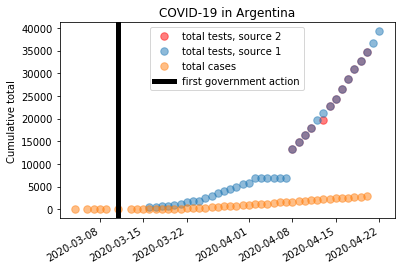

In [909]:
idxslice = pd.IndexSlice['Argentina', testing_df.loc['Argentina',:].date.min():]
testing_multiindex_df.loc[idxslice,:].reset_index(level=0,drop=True).total_tests.plot(marker='.',linestyle='none',label='total tests, source 2',markersize=15,alpha=0.5,color='red')
new_testing_multiindex_df.loc[idxslice, :].reset_index(level=0,drop=True).tests_cumulative.plot(marker='.',linestyle='none',label='total tests, source 1',markersize=15,alpha=0.5)
_ =testing_multiindex_df.loc[idxslice,:].reset_index(level=0,drop=True).total_cases.plot(marker='.',linestyle='none',label='total cases',markersize=15,alpha=0.5)
plt.axvline(min_response_dates.loc['Argentina'], color='black', linewidth=5, label='first government action')
_ = plt.legend()
_ = plt.title('COVID-19 in Argentina')
_ = plt.ylabel('Cumulative total')
_ = plt.xlabel('')

Timestamp('2020-03-04 00:00:00')

In [884]:
testing_multiindex_df.loc[idxslice,:].reset_index(level=0,drop=True).total_cases

date
2020-03-04       1
2020-03-06       2
2020-03-07       8
2020-03-08       9
2020-03-09      12
2020-03-11      19
2020-03-13      31
2020-03-14      34
2020-03-15      45
2020-03-16      56
2020-03-17      65
2020-03-18      79
2020-03-19      97
2020-03-20     128
2020-03-21     158
2020-03-22     225
2020-03-23     266
2020-03-24     301
2020-03-25     387
2020-03-26     502
2020-03-27     589
2020-03-28     690
2020-03-29     745
2020-03-30     820
2020-03-31     966
2020-04-01     966
2020-04-02    1133
2020-04-03    1133
2020-04-04    1265
2020-04-05    1451
2020-04-06    1554
2020-04-07    1628
2020-04-08    1715
2020-04-09    1795
2020-04-10    1894
2020-04-11    1975
2020-04-12    2137
2020-04-13    2203
2020-04-14    2272
2020-04-15    2432
2020-04-16    2432
2020-04-17    2560
2020-04-18    2658
2020-04-19    2828
2020-04-20    2930
Name: total_cases, dtype: int64

In [832]:
countries_with_sufficient_testing_data = []
for country, country_df in testing_df.groupby(by='location'):
    # Total of non-nan elements
    if country_df.total_tests.count() > 2:
        countries_with_sufficient_testing_data.append(country)

In [836]:
testing_multiindex_df = testing_df.set_index([testing_df.index,'date']).sort_index()
testing_multiindex_df.head()

iso_code  total_cases  new_cases  total_deaths  \
location    date                                                        
Afghanistan 2019-12-31      AFG            0          0             0   
            2020-01-01      AFG            0          0             0   
            2020-01-02      AFG            0          0             0   
            2020-01-03      AFG            0          0             0   
            2020-01-04      AFG            0          0             0   

                        new_deaths  total_cases_per_million  \
location    date                                              
Afghanistan 2019-12-31           0                      0.0   
            2020-01-01           0                      0.0   
            2020-01-02           0                      0.0   
            2020-01-03           0                      0.0   
            2020-01-04           0                      0.0   

                        new_cases_per_million  total_deaths_per_million  \
location    date                                                          
Afghanistan 2019-12-31                    0.0                       0.0   
            2020-01-01                    0.0                       0.0   
            2020-01-02                    0.0                       0.0   
            2020-01-03                    0.0                       0.0   
            2020-01-04                    0.0                       0.0   

                        new_deaths_per_million  total_tests  new_tests  \
location    date                                                         
Afghanistan 2019-12-31                     0.0          NaN        NaN   
            2020-01-01                     0.0          NaN        NaN   
            2020-01-02                     0.0          NaN        NaN   
            2020-01-03                     0.0          NaN        NaN   
            2020-01-04                     0.0          NaN        NaN   

                        total_tests_per_thousand  new_tests_per_thousand  \
location    date                                                           
Afghanistan 2019-12-31                       NaN                     NaN   
            2020-01-01                       NaN                     NaN   
            2020-01-02                       NaN                     NaN   
            2020-01-03                       NaN                     NaN   
            2020-01-04                       NaN                     NaN   

                       tests_units  
location    date                    
Afghanistan 2019-12-31         NaN  
            2020-01-01         NaN  
            2020-01-02         NaN  
            2020-01-03         NaN  
            2020-01-04         NaN

In [838]:
testing_multiindex_df.index.intersection(new_testing_multiindex_df.index)

MultiIndex([(             'Brazil', '2020-03-18'),
            (            'Senegal', '2020-04-14'),
            ('Antigua and Barbuda', '2020-04-17'),
            (           'Bulgaria', '2020-03-16'),
            (           'Zimbabwe', '2020-04-01'),
            (              'Japan', '2020-03-22'),
            (            'Estonia', '2020-04-07'),
            (            'Finland', '2020-04-14'),
            (             'Israel', '2020-03-09'),
            (             'Rwanda', '2020-04-20'),
            ...
            (            'Croatia', '2020-03-14'),
            (              'Egypt', '2020-03-25'),
            (           'Paraguay', '2020-03-29'),
            (           'Colombia', '2020-03-29'),
            (            'Namibia', '2020-04-11'),
            (            'Uruguay', '2020-03-28'),
            (            'Bolivia', '2020-04-07'),
            (     'Czech Republic', '2020-02-03'),
            (              'India', '2020-04-09'),
            (  

In [816]:
testing_after_first_known_case_df = testing_multiindex_df.loc[testing_multiindex_df.total_cases.replace(to_replace=0, value=np.nan).dropna().index,:]
testing_after_first_known_case_df

iso_code  total_cases  new_cases  total_deaths  \
location    date                                                        
Afghanistan 2020-02-25      AFG            1          1             0   
            2020-02-26      AFG            1          0             0   
            2020-02-27      AFG            1          0             0   
            2020-02-28      AFG            1          0             0   
            2020-02-29      AFG            1          0             0   
...                         ...          ...        ...           ...   
Zimbabwe    2020-04-16      ZWE           23          6             3   
            2020-04-17      ZWE           24          1             3   
            2020-04-18      ZWE           24          0             3   
            2020-04-19      ZWE           25          1             3   
            2020-04-20      ZWE           25          0             3   

                        new_deaths  total_cases_per_million  \
location    date                                              
Afghanistan 2020-02-25           0                    0.026   
            2020-02-26           0                    0.026   
            2020-02-27           0                    0.026   
            2020-02-28           0                    0.026   
            2020-02-29           0                    0.026   
...                            ...                      ...   
Zimbabwe    2020-04-16           0                    1.547   
            2020-04-17           0                    1.615   
            2020-04-18           0                    1.615   
            2020-04-19           0                    1.682   
            2020-04-20           0                    1.682   

                        new_cases_per_million  total_deaths_per_million  \
location    date                                                          
Afghanistan 2020-02-25                  0.026                     0.000   
            2020-02-26                  0.000                     0.000   
            2020-02-27                  0.000                     0.000   
            2020-02-28                  0.000                     0.000   
            2020-02-29                  0.000                     0.000   
...                                       ...                       ...   
Zimbabwe    2020-04-16                  0.404                     0.202   
            2020-04-17                  0.067                     0.202   
            2020-04-18                  0.000                     0.202   
            2020-04-19                  0.067                     0.202   
            2020-04-20                  0.000                     0.202   

                        new_deaths_per_million  total_tests  new_tests  \
location    date                                                         
Afghanistan 2020-02-25                     0.0          NaN        NaN   
            2020-02-26                     0.0          NaN        NaN   
            2020-02-27                     0.0          NaN        NaN   
            2020-02-28                     0.0          NaN        NaN   
            2020-02-29                     0.0          NaN        NaN   
...                                        ...          ...        ...   
Zimbabwe    2020-04-16                     0.0          NaN        NaN   
            2020-04-17                     0.0          NaN        NaN   
            2020-04-18                     0.0          NaN        NaN   
            2020-04-19                     0.0          NaN        NaN   
            2020-04-20                     0.0          NaN        NaN   

                        total_tests_per_thousand  new_tests_per_thousand  \
location    date                                                           
Afghanistan 2020-02-25                       NaN                     NaN   
            2020-02-26                       NaN                     NaN   
          

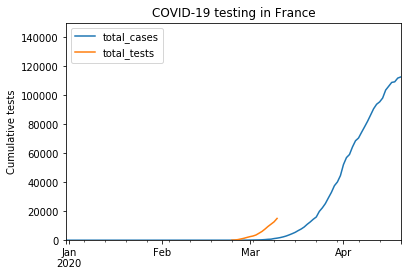

In [793]:
_ = testing_multiindex_df.loc['France',['total_cases','total_tests']].plot()
_ = plt.ylabel('Cumulative tests')
_ = plt.xlabel('')
_ = plt.title('COVID-19 testing in France')
_ = plt.ylim([0, 150000])

In [547]:
testing_multiindex_df.index.get_level_values(0).unique()
testing_and_response_data_countries = start_end_filtered_df.index.intersection(testing_df.index.unique())

The testing data is being used as a reference, so its not necessary to remove the countries which aren't
in the government response data.

In [548]:
start_end_filtered_df = start_end_filtered_df.loc[testing_and_response_data_countries,:]
enacted_ended_df_multiindex = enacted_ended_df_multiindex.loc[testing_and_response_data_countries,:]

Unfortunately there is one more step that needs to be taken, as even though the testing data has data on
some countries, it doesn't contain the actual testing data. Therefore, need to remove countries which do not
have testing data.

Countries where there is actual testing data and case data. 

Only look at the average growth rates after first known case, as to not unfairly decrease the rate before responses.

## Instead of datetime slicing I should have just been using days since first case.

In [549]:
testing_after_first_known_case_df = testing_multiindex_df.loc[testing_multiindex_df.total_cases.replace(to_replace=0, value=np.nan).dropna().index,:]
testing_after_first_known_case_df.head()

iso_code  total_cases  new_cases  total_deaths  \
location  date                                                        
Argentina 2020-03-04      ARG            1          1             0   
          2020-03-06      ARG            2          1             0   
          2020-03-07      ARG            8          6             0   
          2020-03-08      ARG            9          1             1   
          2020-03-09      ARG           12          3             1   

                      new_deaths  total_cases_per_million  \
location  date                                              
Argentina 2020-03-04           0                    0.022   
          2020-03-06           0                    0.044   
          2020-03-07           0                    0.177   
          2020-03-08           1                    0.199   
          2020-03-09           0                    0.266   

                      new_cases_per_million  total_deaths_per_million  \
location  date                                                          
Argentina 2020-03-04                  0.022                     0.000   
          2020-03-06                  0.022                     0.000   
          2020-03-07                  0.133                     0.000   
          2020-03-08                  0.022                     0.022   
          2020-03-09                  0.066                     0.022   

                      new_deaths_per_million  total_tests  new_tests  \
location  date                                                         
Argentina 2020-03-04                   0.000          NaN        NaN   
          2020-03-06                   0.000          NaN        NaN   
          2020-03-07                   0.000          NaN        NaN   
          2020-03-08                   0.022          NaN        NaN   
          2020-03-09                   0.000          NaN        NaN   

                      total_tests_per_thousand  new_tests_per_thousand  \
location  date                                                           
Argentina 2020-03-04                       NaN                     NaN   
          2020-03-06                       NaN                     NaN   
          2020-03-07                       NaN                     NaN   
          2020-03-08                       NaN                     NaN   
          2020-03-09                       NaN                     NaN   

                     tests_units  
location  date                    
Argentina 2020-03-04         NaN  
          2020-03-06         NaN  
          2020-03-07         NaN  
          2020-03-08         NaN  
          2020-03-09         NaN

In [550]:
testing_country_list = testing_multiindex_df.index.get_level_values(level=0).unique()
final_country_list = start_end_filtered_final_df.index.intersection(testing_country_list)
final_country_list

Index(['Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bolivia',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Czech Republic',
       'Denmark', 'Ecuador', 'El Salvador', 'Estonia', 'Finland', 'France',
       'Germany', 'Ghana', 'Greece', 'Hong Kong', 'Hungary', 'India',
       'Indonesia', 'Israel', 'Italy', 'Japan', 'Kenya', 'Malaysia', 'Mexico',
       'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
       'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'Russia', 'Serbia', 'Slovenia', 'South Africa', 'South Korea',
       'Switzerland', 'Thailand', 'Tunisia', 'Turkey', 'Uganda',
       'United States', 'Uruguay', 'Vietnam'],
      dtype='object')

In [551]:
start_end_filtered_final_df = start_end_filtered_df.loc[final_country_list,:] 
enacted_ended_filtered_final_df = enacted_ended_filtered_df.loc[final_country_list,:] 

Redo the multiindex slice computation

In [552]:
enacted_ended_df_multiindex_final = enacted_ended_filtered_final_df.copy()
for c in enacted_ended_filtered_final_df.columns:
    enacted_ended_df_multiindex_final.loc[:, c] = list(zip(enacted_ended_df_multiindex_final.index.tolist(), 
                                               enacted_ended_df_multiindex_final.loc[:, c].tolist()))

In [553]:
def multi_index_slice_to_average_rate(x, testing_df):
    sliced_values = testing_df.loc[x, :]
    sliced_values_of_interest = sliced_values.loc[:, ['total_cases_per_million', 'total_tests']].replace(to_replace=np.nan, value=1.) 
#     avg_case_rate = (sliced_values_of_interest.iloc[-1, 0]
#                               -sliced_values_of_interest.iloc[0, 0])  / len(sliced_values_of_interest)
    avg_case_rate = (sliced_values_of_interest.iloc[-1, 0]/sliced_values_of_interest.iloc[0, 0])**(-1/len(sliced_values_of_interest))
#         test_weight = (sliced_values_of_interest.iloc[-1, 1]
#                        -sliced_values_of_interest.iloc[0, 1])
#         if (test_weight == 0.) or (test_weight == np.nan):
#             test_weight = 1.
#         weighted_avg_rate = avg_case_rate / test_weight
#         return weighted_avg_rate
    return avg_case_rate

These represent the official dates of government action but these dates may not exist in testing data. Therefore, need to check start dates vs. testing data start dates.

testing data typically starts far after response data. therefore cannot weight by testing and still have representation from majority of countries. In that case, just use the average rate of total cases per million, before and after response dates.

In [554]:
start_end_testing_comparison_df = start_end_filtered_final_df.copy()

In [555]:
first_response_dates = start_end_filtered_final_df.min(axis=1).sort_index()
first_response_dates.head(10)

Argentina    2020-03-11
Australia    2020-02-01
Austria      2020-03-09
Bangladesh   2020-01-22
Belgium      2020-03-04
Bolivia      2020-03-12
Canada       2020-01-22
Chile        2020-03-15
Colombia     2020-02-24
Costa Rica   2020-03-10
dtype: datetime64[ns]

In [556]:
first_case_dates = testing_after_first_known_case_df.reset_index(level=1).groupby(level=0).date.min().sort_index()
first_case_dates.head(10)

location
Argentina    2020-03-04
Australia    2020-01-25
Austria      2020-02-26
Bahrain      2020-02-24
Bangladesh   2020-03-09
Belgium      2020-02-04
Bolivia      2020-03-12
Canada       2020-01-26
Chile        2020-03-04
Colombia     2020-03-07
Name: date, dtype: datetime64[ns]

In [765]:
dates_with_test_data = testing_after_first_known_case_df.total_tests.dropna()
dates_with_test_data.head()

location   date      
Argentina  2020-04-08    13330.0
           2020-04-09    14850.0
           2020-04-10    16379.0
           2020-04-11    18027.0
           2020-04-13    19758.0
Name: total_tests, dtype: float64

In [558]:
min_testing_dates = testing_after_first_known_case_df.total_tests.dropna().reset_index(level=1).groupby(level=0).date.min()

In [559]:
after_first_known_test = testing_after_first_known_case_df.loc[testing_after_first_known_case_df.total_tests.dropna().index,:]
after_first_known_test.loc[:, 'total_rate'] = after_first_known_test.total_cases / after_first_known_test.total_tests

In [562]:
first_testing_dates = testing_after_first_known_case_df.total_tests.dropna().reset_index(level=1).groupby(level=0).date.min()
last_testing_dates = testing_after_first_known_case_df.total_tests.dropna().reset_index(level=1).groupby(level=0).date.max()

location
Argentina    2020-04-08
Australia    2020-01-30
Austria      2020-02-26
Bahrain      2020-03-05
Bangladesh   2020-03-09
Name: date, dtype: datetime64[ns]

In [563]:
# convert entire dataframe to index so it can be used to slice testing data, dataframe
first_tmp =  first_testing_dates.reset_index().set_index(['location','date'])
last_tmp =  last_testing_dates.reset_index().set_index(['location','date'])
first_tmp.head()

,
location,date
Argentina,2020-04-08
Australia,2020-01-30
Austria,2020-02-26
Bahrain,2020-03-05
Bangladesh,2020-03-09


In [564]:
test_min = testing_multiindex_df.loc[first_tmp.index, :]
test_max = testing_multiindex_df.loc[last_tmp.index, :]

In [565]:
# reset index so we can subtract datetime variables.
test_max_reset = test_max.reset_index(level=1)
test_min_reset = test_min.reset_index(level=1)
time_differential = (test_max_reset.date - test_min_reset.date).dt.days
testing_rates = np.log(test_max_reset.total_tests / test_min_reset.total_tests) / time_intervals

Because modeling as exponential, the rate is given by $\frac{1}{\Delta t}\ln (\frac{test_f}{test_i}) = r$

In [584]:
test_final_test_initial_time_intervals = (test_max_reset.date - test_min_reset.date).dt.days

In [568]:
reset_tmp = testing_after_first_known_case_df.reset_index(level=1)
reset_tmp.loc[:,'time_differential'] = (reset_tmp.date-test_min_reset.date).dropna().dt.days.values

In [578]:
reset_tmp.loc[test_min_reset.index,'initial_test_number'] = test_min_reset.total_tests

In [638]:
test_final_test_initial_time_intervals

location
Argentina         12
Australia         81
Austria           54
Bahrain           46
Bangladesh        42
                  ..
Uganda             8
United Kingdom    80
United States     44
Uruguay           22
Vietnam           48
Name: date, Length: 68, dtype: int64

In [642]:
test_min_reset.loc['Vietnam'].date- test_max_reset.loc['Vietnam'].date

Timedelta('-48 days +00:00:00')

In [647]:
average_rates_from_first_test_to_last = np.log(test_max_reset.total_tests / test_min_reset.total_tests) * (1.0/(test_final_test_initial_time_intervals+1))
average_rates_from_first_test_to_last

location
Argentina         0.073301
Australia         0.109593
Austria           0.115373
Bahrain           0.060194
Bangladesh        0.122531
                    ...   
Uganda            0.082855
United Kingdom    0.094908
United States     0.164979
Uruguay           0.064254
Vietnam           0.092546
Length: 68, dtype: float64

In [668]:
average_slope_from_first_test_to_last = (test_max_reset.total_tests-test_min_reset.total_tests)*(1.0/(test_final_test_initial_time_intervals+1))
average_slope_from_first_test_to_last

location
Argentina          1633.692308
Australia          5264.524390
Austria            3320.509091
Bahrain            1807.936170
Bangladesh          615.511628
                      ...     
Uganda              389.000000
United Kingdom     4763.790123
United States     88914.711111
Uruguay             430.434783
Vietnam            3298.448980
Length: 68, dtype: float64

In [676]:
reset_tmp.loc[:, 'linear_test_interpolation'] = average_slope_from_first_test_to_last*reset_tmp.time_differential + reset_tmp.initial_test_number

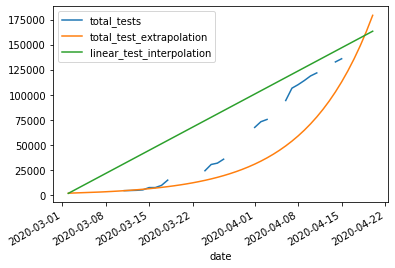

In [761]:
reset_tmp[reset_tmp.time_differential>=0].loc['Vietnam', ['date','total_tests','total_test_extrapolation','linear_test_interpolation']].set_index('date').plot()

In [650]:
reset_tmp.loc[:, 'average_rate'] = average_rates_from_first_test_to_last
test_exp_tmp = reset_tmp.initial_test_number * np.exp(reset_tmp.average_rate*reset_tmp.time_differential)

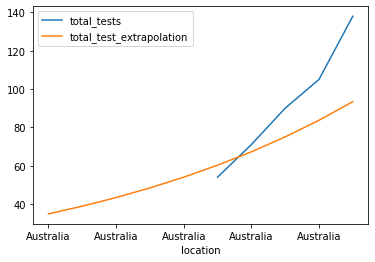

In [749]:
reset_tmp.loc['Australia',['total_tests','total_test_extrapolation']].iloc[:10,:].plot()

In [742]:
reset_tmp.loc['Australia',['total_cases','total_tests','total_test_extrapolation','time_differential']].dropna()

,total_cases,total_tests,total_test_extrapolation,time_differential
location,,,,
Australia,6,54.0,60.254473,0
Australia,7,71.0,67.233361,1
Australia,9,90.0,75.020569,2
Australia,11,105.0,83.709719,3
Australia,11,138.0,93.405278,4
...,...,...,...,...
Australia,6458,380003.0,278512.820888,77
Australia,6497,391530.0,310771.170259,78
Australia,6533,406510.0,346765.796835,79


In [745]:
test_min_reset.loc['Australia','total_tests']

54.0

In [741]:
reset_tmp.iloc[:, -5:]

,time_differential,initial_test_number,average_rate,total_test_extrapolation,linear_test_interpolation
location,,,,,
Argentina,-35,13330.0,0.073301,1102.728622,-43849.230769
Argentina,-33,13330.0,0.073301,1276.841444,-40581.846154
Argentina,-32,13330.0,0.073301,1373.950645,-38948.153846
Argentina,-31,13330.0,0.073301,1478.445413,-37314.461538
Argentina,-30,13330.0,0.073301,1590.887451,-35680.769231
...,...,...,...,...,...
Vietnam,45,1753.0,0.092546,123769.847491,150183.204082
Vietnam,46,1753.0,0.092546,135770.956074,153481.653061
Vietnam,47,1753.0,0.092546,148935.729395,156780.102041


In [626]:
reset_tmp.loc[:, 'average_rate'] = average_rates_from_first_test_to_last
reset_tmp.initial_test_number * (reset_tmp.average_rate**reset_tmp.time_differential)

location
Argentina      1024.789071
Argentina      1186.595805
Argentina      1276.841444
Argentina      1373.950645
Argentina      1478.445413
                 ...      
Vietnam      112829.544631
Vietnam      123769.847491
Vietnam      135770.956074
Vietnam      148935.729395
Vietnam      163377.000000
Length: 3842, dtype: float64

In [630]:
reset_tmp.loc[:, 'total_test_extrapolation'] = reset_tmp.initial_test_number * (reset_tmp.average_rate**(reset_tmp.time_differential+1))

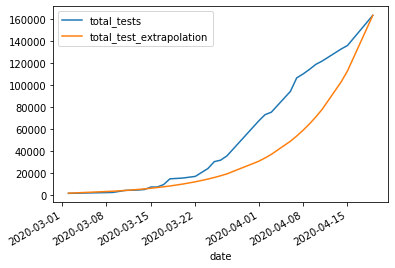

In [631]:
reset_tmp.set_index([reset_tmp.index,'date']).loc['Vietnam', ['total_tests','total_test_extrapolation']].dropna().plot()

Calculate the extrapolation range by comparing first known case date with first reported test date (obviously
there must to have been tests before this date, they just weren't recorded). More concerned with getting the extrapolation right, so don't worry if it doesn't match where there is actual testing data.

In [442]:
extrapolated_time_interval = test_min_reset.date-min_case_dates

In [370]:
shared_index = min_case_dates.index.intersection(min_response_dates.index).intersection(min_testing_dates.index)
shared_index

Index(['Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bolivia',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Czech Republic',
       'Denmark', 'Ecuador', 'El Salvador', 'Estonia', 'Finland', 'France',
       'Germany', 'Ghana', 'Greece', 'Hungary', 'India', 'Indonesia', 'Israel',
       'Italy', 'Japan', 'Kenya', 'Malaysia', 'Mexico', 'Netherlands',
       'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama', 'Paraguay',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Serbia', 'Singapore', 'Slovenia', 'South Africa', 'South Korea',
       'Spain', 'Switzerland', 'Thailand', 'Tunisia', 'Turkey', 'Uganda',
       'United States', 'Uruguay', 'Vietnam'],
      dtype='object')

In [249]:
min_case_dates.loc[shared_index].head(10)

Argentina    2020-03-04
Australia    2020-01-25
Austria      2020-02-26
Bangladesh   2020-03-09
Belgium      2020-02-04
Bolivia      2020-03-12
Canada       2020-01-26
Chile        2020-03-04
Colombia     2020-03-07
Costa Rica   2020-03-07
Name: date, dtype: datetime64[ns]

In [250]:
min_response_dates.loc[shared_index].head(10)

Argentina    2020-03-11
Australia    2020-02-01
Austria      2020-03-09
Bangladesh   2020-01-22
Belgium      2020-03-04
Bolivia      2020-03-12
Canada       2020-01-22
Chile        2020-03-15
Colombia     2020-02-24
Costa Rica   2020-03-10
dtype: datetime64[ns]

In [256]:
case_response_differential = min_case_dates.loc[shared_index]-min_response_dates.loc[shared_index]

In [324]:
negative_case_differential_index = case_response_differential.index.where(case_response_differential.dt.days < 0)

In [372]:
case_testing_differential = min_case_dates.loc[shared_index]-min_testing_dates.loc[shared_index]
case_testing_differential

Argentina        -35 days
Australia         -5 days
Austria            0 days
Bangladesh         0 days
Belgium          -26 days
Bolivia           -9 days
Canada           -52 days
Chile            -28 days
Colombia          -8 days
Costa Rica        -4 days
Cuba             -10 days
Czech Republic     0 days
Denmark          -22 days
Ecuador          -17 days
El Salvador      -24 days
Estonia            0 days
Finland          -42 days
France           -30 days
Germany          -40 days
Ghana            -15 days
Greece           -22 days
Hungary           -2 days
India            -43 days
Indonesia        -14 days
Israel             0 days
Italy            -24 days
Japan            -42 days
Kenya             -3 days
Malaysia         -20 days
Mexico             0 days
Netherlands      -15 days
New Zealand      -15 days
Nigeria          -40 days
Norway           -18 days
Pakistan         -13 days
Panama             0 days
Paraguay          -3 days
Peru               0 days
Philippines 

In [381]:
response_testing_differential = min_testing_dates.loc[shared_index]-min_response_dates.loc[shared_index]
response_testing_differential

Argentina         28 days
Australia         -2 days
Austria          -12 days
Bangladesh        47 days
Belgium           -3 days
Bolivia            9 days
Canada            56 days
Chile             17 days
Colombia          20 days
Costa Rica         1 days
Cuba               2 days
Czech Republic    -5 days
Denmark           17 days
Ecuador           16 days
El Salvador       72 days
Estonia          -13 days
Finland            0 days
France            32 days
Germany           11 days
Ghana             64 days
Greece            20 days
Hungary           -2 days
India             47 days
Indonesia         61 days
Israel            20 days
Italy             32 days
Japan             50 days
Kenya             57 days
Malaysia          15 days
Mexico             1 days
Netherlands        8 days
New Zealand       41 days
Nigeria           77 days
Norway             6 days
Pakistan          17 days
Panama            42 days
Paraguay           1 days
Peru               1 days
Philippines 

In [334]:
final_index = negative_case_differential_index.dropna().intersection(start_end_filtered_final_df.index).intersection(testing_df.index.unique())

In [337]:
enacted_ended_df_multiindex_final.loc[final_index, :].shape

(30, 10)

In [342]:
start_end_final = start_end_filtered_final_df.loc[final_index, :]
slice_final = enacted_ended_df_multiindex_final.loc[final_index, :]
testing_final = testing_after_first_known_case_df.loc[final_index, :]

In [353]:
start_end_final.min(axis=1).max()

Timestamp('2020-03-20 00:00:00')

In [358]:
slice_final.head()

,School_closing_before,School_closing_after,Workplace_closing_before,Workplace_closing_after,Cancel_public_events_before,Cancel_public_events_after,Restrictions_on_internal_movement_before,Restrictions_on_internal_movement_after,International_travel_controls_before,International_travel_controls_after
Argentina,"(Argentina, slice(None, Timestamp('2020-03-16 ...","(Argentina, slice(Timestamp('2020-03-16 00:00:...","(Argentina, slice(None, Timestamp('2020-03-16 ...","(Argentina, slice(Timestamp('2020-03-16 00:00:...","(Argentina, slice(None, Timestamp('2020-03-13 ...","(Argentina, slice(Timestamp('2020-03-13 00:00:...","(Argentina, slice(None, Timestamp('2020-03-20 ...","(Argentina, slice(Timestamp('2020-03-20 00:00:...","(Argentina, slice(None, Timestamp('2020-03-11 ...","(Argentina, slice(Timestamp('2020-03-11 00:00:..."
Australia,"(Australia, slice(None, Timestamp('2020-03-22 ...","(Australia, slice(Timestamp('2020-03-22 00:00:...","(Australia, slice(None, Timestamp('2020-03-24 ...","(Australia, slice(Timestamp('2020-03-24 00:00:...","(Australia, slice(None, Timestamp('2020-03-16 ...","(Australia, slice(Timestamp('2020-03-16 00:00:...","(Australia, slice(None, Timestamp('2020-03-19 ...","(Australia, slice(Timestamp('2020-03-19 00:00:...","(Australia, slice(None, Timestamp('2020-02-01 ...","(Australia, slice(Timestamp('2020-02-01 00:00:..."
Austria,"(Austria, slice(None, Timestamp('2020-03-16 00...","(Austria, slice(Timestamp('2020-03-16 00:00:00...","(Austria, slice(None, Timestamp('2020-03-12 00...","(Austria, slice(Timestamp('2020-03-12 00:00:00...","(Austria, slice(None, Timestamp('2020-03-11 00...","(Austria, slice(Timestamp('2020-03-11 00:00:00...","(Austria, slice(None, Timestamp('2020-03-13 00...","(Austria, slice(Timestamp('2020-03-13 00:00:00...","(Austria, slice(None, Timestamp('2020-03-09 00...","(Austria, slice(Timestamp('2020-03-09 00:00:00..."
Belgium,"(Belgium, slice(None, Timestamp('2020-03-14 00...","(Belgium, slice(Timestamp('2020-03-14 00:00:00...","(Belgium, slice(None, Timestamp('2020-03-13 00...","(Belgium, slice(Timestamp('2020-03-13 00:00:00...","(Belgium, slice(None, Timestamp('2020-03-10 00...","(Belgium, slice(Timestamp('2020-03-10 00:00:00...","(Belgium, slice(None, Timestamp('2020-03-18 00...","(Belgium, slice(Timestamp('2020-03-18 00:00:00...","(Belgium, slice(None, Timestamp('2020-03-04 00...","(Belgium, slice(Timestamp('2020-03-04 00:00:00..."
Chile,"(Chile, slice(None, Timestamp('2020-03-15 00:0...","(Chile, slice(Timestamp('2020-03-15 00:00:00')...","(Chile, slice(None, Timestamp('2020-03-16 00:0...","(Chile, slice(Timestamp('2020-03-16 00:00:00')...","(Chile, slice(None, Timestamp('2020-03-16 00:0...","(Chile, slice(Timestamp('2020-03-16 00:00:00')...","(Chile, slice(None, Timestamp('2020-03-25 00:0...","(Chile, slice(Timestamp('2020-03-25 00:00:00')...","(Chile, slice(None, Timestamp('2020-03-18 00:0...","(Chile, slice(Timestamp('2020-03-18 00:00:00')..."


In [385]:
average_rate_df = slice_final.copy()
for col in average_rate_df.columns:
    average_rate_df.loc[:, col] = average_rate_df.loc[:, col].apply(multi_index_slice_to_average_rate, args=(testing_final, ))

In [386]:
average_rate_df

,School_closing_before,School_closing_after,Workplace_closing_before,Workplace_closing_after,Cancel_public_events_before,Cancel_public_events_after,Restrictions_on_internal_movement_before,Restrictions_on_internal_movement_after,International_travel_controls_before,International_travel_controls_after
Argentina,0.668244,0.888831,0.668244,0.888831,0.611766,0.882816,0.706821,0.900181,0.611687,0.873887
Australia,0.886206,0.929389,0.882294,0.944745,0.896134,0.902980,0.891085,0.914205,0.759296,0.915151
Austria,0.738448,0.905613,0.740241,0.884854,0.740267,0.880208,0.736645,0.892107,0.738992,0.856010
Belgium,0.853648,0.890650,0.857574,0.874039,0.858803,0.871331,0.850430,0.889162,0.917945,0.828132
Chile,0.687799,0.849436,0.697481,0.841863,0.697481,0.847664,0.722269,0.893916,0.684384,0.881024
Costa Rica,0.538734,0.914790,0.480478,0.898569,0.480478,0.898569,0.742382,0.947110,0.700628,0.923017
Cuba,0.771832,0.882021,0.756573,0.869076,0.756573,0.869076,0.756573,0.869076,0.756573,0.869076
Czech Republic,0.737490,0.874619,0.740105,0.887854,0.737490,0.874619,0.735946,0.901694,0.735136,0.859493
Denmark,0.665555,0.928462,0.671570,0.904278,0.717032,0.852174,0.765020,0.838205,0.765020,0.844088
Ecuador,0.702222,0.838808,0.713274,0.849988,0.702222,0.838808,0.713274,0.849988,0.409447,0.836424


In [357]:
slice_final.iloc[:,0].apply(multi_index_slice_to_average_rate, args=(testing_final, ))

('Argentina', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Australia', slice(None, Timestamp('2020-03-22 00:00:00'), None))
('Austria', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Belgium', slice(None, Timestamp('2020-03-14 00:00:00'), None))
('Chile', slice(None, Timestamp('2020-03-15 00:00:00'), None))
('Costa Rica', slice(None, Timestamp('2020-03-12 00:00:00'), None))
('Cuba', slice(None, Timestamp('2020-03-24 00:00:00'), None))
('Czech Republic', slice(None, Timestamp('2020-03-11 00:00:00'), None))
('Denmark', slice(None, Timestamp('2020-03-13 00:00:00'), None))
('Ecuador', slice(None, Timestamp('2020-03-13 00:00:00'), None))
('Estonia', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Finland', slice(None, Timestamp('2020-03-18 00:00:00'), None))
('Germany', slice(None, Timestamp('2020-02-26 00:00:00'), None))
('Greece', slice(None, Timestamp('2020-03-05 00:00:00'), None))
('Hungary', slice(None, Timestamp('2020-03-11 00:00:00'), None))
('Malaysia', slic

Argentina         0.121700
Australia         0.741724
Austria           4.763300
Belgium           1.203675
Chile             0.285364
Costa Rica        0.824600
Cuba              0.326700
Czech Republic    0.560300
Denmark           7.283500
Ecuador           0.113375
Estonia           9.857923
Finland           1.275422
Germany           0.006367
Greece            0.143833
Hungary           0.172500
Malaysia          0.390566
Netherlands       2.092643
Norway            6.001133
Paraguay          0.000000
Philippines       0.011650
Poland            0.113286
Portugal          0.677636
Slovenia          9.532909
South Korea       0.018200
Spain             0.330974
Switzerland       5.797647
Thailand          0.020732
Tunisia           0.000000
United States     0.007163
Vietnam           0.005545
Name: School_closing_before, dtype: float64

In [99]:
enacted_ended_df_multiindex_final.iloc[:,0].apply(multi_index_slice_to_average_rate, args=(testing_multiindex_df_tmp, ))

('Argentina', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Australia', slice(None, Timestamp('2020-03-22 00:00:00'), None))
('Austria', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Bangladesh', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Belgium', slice(None, Timestamp('2020-03-14 00:00:00'), None))
('Bolivia', slice(None, Timestamp('2020-03-13 00:00:00'), None))
('Canada', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Chile', slice(None, Timestamp('2020-03-15 00:00:00'), None))
('Colombia', slice(None, Timestamp('2020-03-16 00:00:00'), None))
('Costa Rica', slice(None, Timestamp('2020-03-12 00:00:00'), None))
('Cuba', slice(None, Timestamp('2020-03-24 00:00:00'), None))
('Czech Republic', slice(None, Timestamp('2020-03-11 00:00:00'), None))
('Denmark', slice(None, Timestamp('2020-03-13 00:00:00'), None))
('Ecuador', slice(None, Timestamp('2020-03-13 00:00:00'), None))
('El Salvador', slice(None, Timestamp('2020-03-12 00:00:00'), None))
('Estonia

Argentina                  NaN
Australia         6.787325e-06
Austria           6.075537e-04
Bangladesh        0.000000e+00
Belgium           2.861362e-04
Bolivia                    NaN
Canada                     NaN
Chile                      NaN
Colombia         -6.345566e-05
Costa Rica        9.926966e-03
Cuba              2.007576e-03
Czech Republic    8.399006e-05
Denmark                    NaN
Ecuador                    NaN
El Salvador                NaN
Estonia           3.481809e-03
Finland           1.454483e-03
France            7.930271e-05
Germany                    NaN
Ghana                      NaN
Greece                     NaN
Hong Kong                  NaN
Hungary           1.064204e-04
India                      NaN
Indonesia                  NaN
Israel            4.229396e-05
Italy                      NaN
Japan             2.267943e-04
Kenya             0.000000e+00
Malaysia          1.403084e-04
Mexico            2.746403e-05
Netherlands                NaN
New Zeal

Convert the testing dataframe to the same standard of country names then slice out all countries that are not in
the current pool of names. 

slice the countries to those our reduced set.

In [337]:
dir(slice)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'indices',
 'start',
 'step',
 'stop']

In [ ]:
def before_after_slice(df, date_tuple)

In [106]:
for country, country_df in testing_filtered_df.groupby(level=0):
    print(country)


Afghanistan
Algeria
Angola
Argentina
Australia
Austria
Azerbaijan
Bangladesh
Barbados
Belgium
Belize
Bermuda
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Bulgaria
Burkina Faso
Canada
Chile
China
Colombia
Costa Rica
Croatia
Cuba
Cyprus
Czech Republic
Democratic Republic of Congo
Denmark
Djibouti
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Finland
France
Gabon
Gambia
Germany
Ghana
Greece
Greenland
Guam
Guatemala
Guyana
Honduras
Hong Kong
Hungary
India
Indonesia
Iraq
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Lebanon
Libya
Madagascar
Malawi
Malaysia
Mauritania
Mauritius
Mexico
Mongolia
Morocco
Myanmar
Netherlands
New Zealand
Nigeria
Norway
Oman
Pakistan
Panama
Papua New Guinea
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Russia
Rwanda
San Marino
Saudi Arabia
Serbia
Seychelles
Sierra Leone
Singapore
Slovenia
South Africa
South Korea
South Sudan
Spain
Sri Lanka
Sudan
Switzerland
Syria
Thailand
Trinidad and Tobago
Tunisia
Turkey
Uganda


In [258]:
global_cases = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv'
g = pd.read_csv(global_cases)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,4,4,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


In [ ]:
IHME_data = pd.read_csv('./ihme-covid19/2020_04_12.02/Hospitalization_all_locs.csv')

In [ ]:
dir_ =  'C:\\Users\\Matt\\Desktop\\statmethods\\group_project\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format0\\'
file = dir_ + '01-23-2020.csv'

In [ ]:
dir_ =  'C:\\Users\\Matt\\Desktop\\statmethods\\group_project\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format0\\'
file = dir_ + '01-23-2020.csv'

In [ ]:
dir0 = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format0\\'
dir1 = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format1\\'
dir2 = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format2\\'

In [ ]:
uc =  '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_US.csv'
ud =  '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_deaths_US.csv'

In [ ]:
us_cases = pd.read_csv(uc)
us_deaths = pd.read_csv(ud)
us_deaths['type']='Dead'
us_cases['type']='Confirmed'

In [ ]:
pd.concat((us_cases, us_deaths)).sort_index(axis=1).iloc[:, -13:]

In [ ]:
us_deaths.set_index('Province_State').loc[:, '1/22/20':].groupby(level=0).sum()

In [ ]:
dead=us_deaths[us_deaths['Province_State'].isin(['Michigan', 'Georgia', 'New York'])].groupby(by='Province_State').sum().loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns
confirmed=us_cases[us_cases['Province_State'].isin(['Michigan', 'Georgia', 'New York'])].groupby(by='Province_State').sum().loc[:,'1/22/20':]
confirmed.head()

In [ ]:
rate = dead / confirmed

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=200)
(100*rate.loc[:, '2/21/20':]).transpose().plot().legend(bbox_to_anchor=(1, 1))
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
plt.grid(True, axis='both')
plt.title('Death rate by state')
plt.savefig('death_rate_NY_MI_GA.png', bbox_inches='tight')

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, sharey=True,  figsize=(20,5), dpi=200)
confirmed.loc[:, '2/21/20':].transpose().plot(ax=ax).legend(bbox_to_anchor=(0.2, 1))
dead.loc[:, '2/21/20':].transpose().plot(ax=ax2).legend(bbox_to_anchor=(0.2, 1))
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_title('Number of confirmed cases vs. time')
ax2.set_title('Number of diseased vs. time')
ax.grid(True, axis='both')
ax2.grid(True, axis='both')
plt.savefig('cases_vs_dead_comparison_GA_NY_MI.png', bbox_inches='tight')

In [ ]:
testdat = pd.read_csv('full-list-cumulative-total-tests-per-million.csv')
testdat

In [ ]:
def top_5_counties(state_df, state_name):
    state = state_df[(state_df.Province_State==state_name)]
    state = state.drop(columns=['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key','Province_State'])
    top5_counties = state.groupby(by='Admin2').sum().sum(axis=1).sort_values(ascending=False)[:5].index.tolist()
    state_info = state[state.Admin2.isin(top5_counties)].set_index('Admin2').transpose()
    state_info.columns.name = 'County'
    return state_info

In [ ]:
not_of_interest = ['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key']

In [ ]:
mich = u[(u.Province_State=='Michigan')]
mich = mich.drop(columns=['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key','Province_State'])

In [ ]:
michtop5_counties = mich.groupby(by='Admin2').sum().sum(axis=1).sort_values(ascending=False)[:5].index.tolist()

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(20,5), sharey=True)
top_5_counties(u, 'Michigan').plot(ax=ax)
top_5_counties(u, 'New York').plot(ax=ax2)
_ = plt.yscale('log')
_ = plt.xlabel('Date')
_ = plt.ylabel('No. Cases')

In [ ]:
top_5_counties(u, 'Michigan').sum(axis=1)

In [ ]:
top_5_counties(u, 'Michigan').transpose().replace(0, np.nan).bfill(1).iloc[:, 0]

In [ ]:
timeseries = pd.concat((top_5_counties(u, 'New York').loc['3/2/20':, :], top_5_counties(u, 'Michigan').loc['3/11/20':, :]),axis=1).replace(to_replace=0, value=np.nan)

In [ ]:
rotations = timeseries.isna().sum().tolist()

timeseries2 = timeseries.copy()
for i, c in enumerate(timeseries2.columns):
    timeseries2[c]=np.roll(timeseries2[c], -rotations[i],axis=0)

In [ ]:
tmp = timeseries2.Oakland
timeseries2=timeseries2.drop(columns='Oakland')

In [ ]:
ax = timeseries2.reset_index(drop=True).plot()#.legend()
_  = tmp.reset_index(drop=True).plot(color='r', ax=ax, linewidth=6, label='Oakland')
plt.legend(bbox_to_anchor=(1, 1))
_ = plt.yscale('log')
_ = plt.ylabel('No. Cases')
_ = plt.xlabel('Days since first recorded case')
_ = plt.title('COVID growth in top five counties from NY and MI')

In [ ]:
ax = timeseries2.reset_index(drop=True).plot()#.legend(bbox_to_anchor=(1, 1))
_  = tmp.reset_index(drop=True).plot(color='r', ax=ax, linewidth=6,label='Oakland')
plt.legend()
_ = plt.ylabel('No. Cases')
_ = plt.xlabel('Days since first recorded case')
_ = plt.title('COVID growth in top five counties from NY and MI')

In [ ]:
top_5_counties(u, 'New York').transpose().replace(0, np.nan).bfill(1).iloc[:, 0]

In [ ]:
# fig = plt.figure()
ax = top_5_counties(u, 'Michigan').plot(figsize=(10,10))
top_5_counties(u, 'New York').plot(ax=ax)
_ = plt.yscale('log')
_ = plt.xlabel('Date')
_ = plt.ylabel('No. Cases')

In [ ]:
compare = u[(u.Province_State=='Michigan') | (u.Province_State=='New York') | (u.Province_State=='Georgia')]
ctest = compare.drop(columns=not_of_interest).groupby('Province_State').sum().transpose()#.plot()
_ = ctest.plot()
plt.yscale('log')

In [ ]:
ctest2.reset_index(drop=True).plot().legend(bbox_to_anchor=(1, 1))
_ = plt.yscale('log')
_ = plt.ylabel('No. Cases')
_ = plt.xlabel('Days since first recorded case')
_ = plt.title('COVID growth in GA, MI, NY')

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot(nedcf, label='New York')
ax.plot(medcf, label='Michigan')
_ = ax.legend()
ax.set_ylabel('No. Cases')
ax.set_xlabel('No. days since first recorded case')

ax2.plot(nedcf, label='New York')
ax2.plot(medcf, label='Michigan')
_ = ax2.legend()
ax2.set_ylabel('No. Cases')
ax2.set_xlabel('No. days since first recorded case')
ax2.set_yscale('log')

In [ ]:
stateagg = compare.drop(columns=not_of_interest).groupby('Province_State').sum().astype(float)#.apply(np.log10)
stateagg.index.name = None

In [ ]:
mval = stateagg.transpose().values[:, 0]
nval = stateagg.transpose().values[:, 1]

In [ ]:
nedcf = nval[-31:]

In [ ]:
medcf = np.roll(mval,-8)[-31:]

In [ ]:
medcf[np.where(medcf==0)]=np.nan

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot(nedcf, label='New York')
ax.plot(medcf, label='Michigan')
_ = ax.legend()
ax.set_ylabel('No. Cases')
ax.set_xlabel('No. days since first recorded case')

ax2.plot(nedcf, label='New York')
ax2.plot(medcf, label='Michigan')
_ = ax2.legend()
ax2.set_ylabel('No. Cases')
ax2.set_xlabel('No. days since first recorded case')
ax2.set_yscale('log')

In [ ]:
not_of_interest = ['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key']

In [ ]:
gc = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv'
gd = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_deaths_global.csv'
gr = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_recovered_global.csv'

In [ ]:
global_confirmed = pd.read_csv(gc)
global_dead = pd.read_csv(gd)
global_recovered = pd.read_csv(gr)

In [ ]:
global_recovered_dates_only = global_recovered.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()
global_confirmed_dates_only = global_confirmed.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()
global_dead_dates_only = global_dead.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()

In [ ]:
global_dead['type']='Dead'
global_confirmed['type']='Confirmed'
global_recovered['type']='Recovered'

In [ ]:
dead=global_dead[global_dead['Country/Region'].isin(['Germany', 'Italy', 'US'])].set_index('Country/Region').loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns
confirmed=global_confirmed[global_confirmed['Country/Region'].isin(['Germany', 'Italy', 'US'])].set_index('Country/Region').loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns

In [ ]:
rate = dead/confirmed

In [ ]:
(100*rate.loc[:, '2/21/20':]).transpose().plot().legend(bbox_to_anchor=(1, 1))
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
plt.grid(True, axis='both')
plt.title('Death rate by country')
plt.savefig('death_rate_GR_ITA_USA.png', bbox_inches='tight')

In [ ]:
global_dead = global_dead.sort_index(axis=1)
global_confirmed = global_confirmed.sort_index(axis=1)
global_recovered = global_recovered.sort_index(axis=1)

In [ ]:
g11.plot(figsize=(10,10)).legend(bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.ylabel('No. Cases')
plt.xlabel('Date')
plt.grid(True, axis='both')
plt.title('Top 10 countries (+ South Korea) by case number')
plt.savefig('top_10_countries.png', bbox_inches='tight')

In [ ]:
dsum = global_dead_dates_only.sum()
csum = global_confirmed_dates_only.sum()
drsum = 100*dsum/csum
drsum.plot()
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
_ = plt.title('Average global death rate vs. time')
plt.grid(True, axis='both')
plt.savefig('death_rate_global.png', bbox_inches='tight')

In [ ]:
split_data = re.split(pattern='N2O\S+yr', string=data)[1]
df_tmp = pd.read_csv(StringIO(split_data), 
             sep=('\s+'), 
             skiprows=1, 
                 usecols=[0,1,2,3,4,5], 
             engine='python')

for i, f in enumerate(glob.glob('.\\N2O\\*')):
    with open(f, 'r') as file:
        data = file.read()
    split_data = ''.join(re.split(pattern=r'(N2O\S+yr)', string=data)[1:])
    df_tmp = pd.read_csv(StringIO(split_data), 
                 sep=('\s+'), 
#                 skiprows=1, 
#                 usecols=[0,1,2,3,4,5], 
                 engine='python')
    df_tmp.index = pd.to_datetime(df_tmp.iloc[:,0].astype(str) + '-' 
                                  + df_tmp.iloc[:,1].astype(str) + '-' 
                                  + df_tmp.iloc[:,2].astype(str))
    df_tmp.drop(columns=df_tmp.columns.tolist()[:3], inplace=True)
    if i == 0:
        n2o = df_tmp
    else:
        n2o = n2o.join(df_tmp, how='inner')
    
